## Shuffle Heroes

I would like to shuffle the heroes on each team during training. I'm hoping this provides some form of regularization (but I have no clue if it actually will).

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

import tensorflow as tf
import jax
import jax.numpy as jnp
import functools
import optax

from flax.core import frozen_dict
from flax import struct
from flax import linen as nn
from flax.training import train_state

from matplotlib import pyplot as plt

tf.__version__

'2.7.0'

In [8]:
df = pd.read_csv("training_set_large.csv")
df

,hero0,hero1,hero2,hero3,hero4,hero5,hero6,hero7,hero8,hero9,radiant_win
0,23,26,36,42,119,74,104,100,54,47,1.0
1,126,8,30,17,14,39,26,123,2,54,0.0
2,40,4,52,8,93,44,108,5,59,58,1.0
3,47,101,42,109,1,81,67,35,28,50,1.0
4,26,14,76,70,81,23,58,54,64,34,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4212420,85,112,46,86,7,39,54,120,26,126,0.0
4212421,83,38,11,54,90,74,101,104,94,50,1.0
4212422,33,12,34,71,68,126,2,80,119,105,1.0
4212423,88,135,93,52,30,108,67,25,21,13,1.0


In [9]:
# Create train/valid set
train_df = df.iloc[:-5000]
test_df = df.iloc[-5000:]

len(train_df), len(test_df)

(4207425, 5000)

In [10]:
@struct.dataclass
class DotaModelConfig:
  """Global hyperparameters for our MovieLens Model"""
  heros_size: int = int(df.max().max() + 1)   # 1-indexed 
  emb_dim: int = 8
  dense_size_0: int = 32
  dense_size_1: int = 4
  out_size: int = 1
  num_epochs: int = 20
  batch_size: int = 1000
  lr: float = 0.01

In [11]:
class DotaModel(nn.Module):
  """A simple embedding model."""

  config: DotaModelConfig

  @nn.compact
  def __call__(self, heros):
    
    cfg = self.config
    
    hero0, hero1, hero2, hero3, hero4, hero5, hero6, hero7, hero8, hero9 = heros
            
    hero0_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero0')(hero0)
    hero1_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero1')(hero1)
    hero2_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero2')(hero2)
    hero3_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero3')(hero3)
    hero4_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero4')(hero4)

    hero5_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero5')(hero5)
    hero6_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero6')(hero6)
    hero7_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero7')(hero7)
    hero8_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero8')(hero8)
    hero9_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero9')(hero9)

    x = jnp.concatenate((hero0_embed, hero1_embed, hero2_embed, hero3_embed, hero4_embed, hero5_embed, hero6_embed, hero7_embed, hero8_embed, hero9_embed), axis=-1)
    x = jnp.squeeze(x)
        
    x = nn.Dense(cfg.dense_size_0, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.dense_size_1, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.out_size, kernel_init=nn.initializers.kaiming_uniform())(x)

    return x

In [12]:
@functools.partial(jax.jit)
def sigmoid(x):
   return 1/(1 + jnp.exp(-x))

In [13]:
@functools.partial(jax.jit, static_argnums=(0))
def apply_model(cfg, state, heros, radiant_win):
  
  def loss_fn(params):
    logits = DotaModel(cfg).apply({'params': params}, heros)
    logits = jnp.squeeze(logits)
    loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=radiant_win))
    return loss, logits
 
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  
  y_pred = jnp.round(sigmoid(logits))
  accuracy = jnp.mean(y_pred == radiant_win)
  return grads, loss, accuracy

In [14]:
@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [19]:
x = [1,2,3]

In [22]:
def train_epoch(cfg, state, train_df, rng):
  """Train for a single epoch."""
  train_df_size = len(train_df)
  steps_per_epoch = train_df_size // cfg.batch_size
  
  perms = jax.random.permutation(rng, train_df_size)
  perms = perms[:steps_per_epoch * cfg.batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, cfg.batch_size))
  
  epoch_loss = []
  epoch_accuracy = []

  for perm in perms:
    # Shuffle heroes on each team 
    radiant = [train_df.iloc[perm]['hero0'].values, train_df.iloc[perm]['hero1'].values, 
              train_df.iloc[perm]['hero2'].values, train_df.iloc[perm]['hero3'].values,
              train_df.iloc[perm]['hero4'].values]
    np.random.shuffle(radiant)
    batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4 = radiant
    
    dire = [train_df.iloc[perm]['hero5'].values, train_df.iloc[perm]['hero6'].values, 
              train_df.iloc[perm]['hero7'].values, train_df.iloc[perm]['hero8'].values,
              train_df.iloc[perm]['hero9'].values]
    np.random.shuffle(dire)
    batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9 = dire
    
    batch_heros = (batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4, 
                   batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9)
    
    # y
    batch_radiant_win = train_df.iloc[perm]['radiant_win'].values

    grads, loss, accuracy = apply_model(cfg, state, batch_heros, batch_radiant_win)
    state = update_model(state, grads)
    
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

In [23]:
def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  model = DotaModel(config)
  
  # TODO(joshvarty): Probably don't need to use 5 here. Could use
  # config.batch_size though.
  hero_0_fake = jnp.zeros((5,1), jnp.int32)
  hero_1_fake = jnp.zeros((5,1), jnp.int32)
  hero_2_fake = jnp.zeros((5,1), jnp.int32)
  hero_3_fake = jnp.zeros((5,1), jnp.int32)
  hero_4_fake = jnp.zeros((5,1), jnp.int32)
  hero_5_fake = jnp.zeros((5,1), jnp.int32)
  hero_6_fake = jnp.zeros((5,1), jnp.int32)
  hero_7_fake = jnp.zeros((5,1), jnp.int32)
  hero_8_fake = jnp.zeros((5,1), jnp.int32)
  hero_9_fake = jnp.zeros((5,1), jnp.int32)
    
  heros = (hero_0_fake, hero_1_fake, hero_2_fake, hero_3_fake, hero_4_fake, hero_5_fake, hero_6_fake, hero_7_fake, hero_8_fake, hero_9_fake)
  
  # Pass fake values through our model to initialize the parameters
  params = model.init(rng, heros)['params']
  
  steps_per_epoch = len(train_df) // config.batch_size
  lr = optax.linear_onecycle_schedule(config.num_epochs * steps_per_epoch, config.lr)
  #tx = optax.adagrad(lr)
  tx = optax.adam(lr)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [24]:
def train_and_evaluate(config, train_df, test_df):
  rng = jax.random.PRNGKey(0)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)
  
  train_accuracies = []
  test_accuracies = []
  
  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(config, state, train_df, rng)
    
    batch_hero0 = test_df['hero0'].values
    batch_hero1 = test_df['hero1'].values
    batch_hero2 = test_df['hero2'].values
    batch_hero3 = test_df['hero3'].values
    batch_hero4 = test_df['hero4'].values
    batch_hero5 = test_df['hero5'].values
    batch_hero6 = test_df['hero6'].values
    batch_hero7 = test_df['hero7'].values
    batch_hero8 = test_df['hero8'].values
    batch_hero9 = test_df['hero9'].values

    batch_heros = (batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4, 
                   batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9)

    batch_radiant_win = test_df['radiant_win'].values
    _, test_loss, test_accuracy = apply_model(config, state, batch_heros, batch_radiant_win)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.4f, test_loss: %.4f, test_accuracy: %.4f'
        % (epoch, train_loss, train_accuracy, test_loss, test_accuracy))
    
  return state, train_accuracies, test_accuracies

In [25]:
tf.config.experimental.set_visible_devices([], 'GPU')
config = DotaModelConfig()

state, train_accuracies, test_accuracies = train_and_evaluate(config, train_df, test_df)

epoch:  1, train_loss: 0.6830, train_accuracy: 0.5556, test_loss: 0.6829, test_accuracy: 0.5594
epoch:  2, train_loss: 0.6806, train_accuracy: 0.5632, test_loss: 0.6846, test_accuracy: 0.5578
epoch:  3, train_loss: 0.6805, train_accuracy: 0.5635, test_loss: 0.6852, test_accuracy: 0.5498
epoch:  4, train_loss: 0.6796, train_accuracy: 0.5659, test_loss: 0.6835, test_accuracy: 0.5624
epoch:  5, train_loss: 0.6787, train_accuracy: 0.5676, test_loss: 0.6845, test_accuracy: 0.5558
epoch:  6, train_loss: 0.6786, train_accuracy: 0.5685, test_loss: 0.6832, test_accuracy: 0.5586
epoch:  7, train_loss: 0.6783, train_accuracy: 0.5690, test_loss: 0.6822, test_accuracy: 0.5684
epoch:  8, train_loss: 0.6778, train_accuracy: 0.5697, test_loss: 0.6818, test_accuracy: 0.5640
epoch:  9, train_loss: 0.6775, train_accuracy: 0.5704, test_loss: 0.6827, test_accuracy: 0.5632
epoch: 10, train_loss: 0.6771, train_accuracy: 0.5712, test_loss: 0.6828, test_accuracy: 0.5620
epoch: 11, train_loss: 0.6768, train_acc

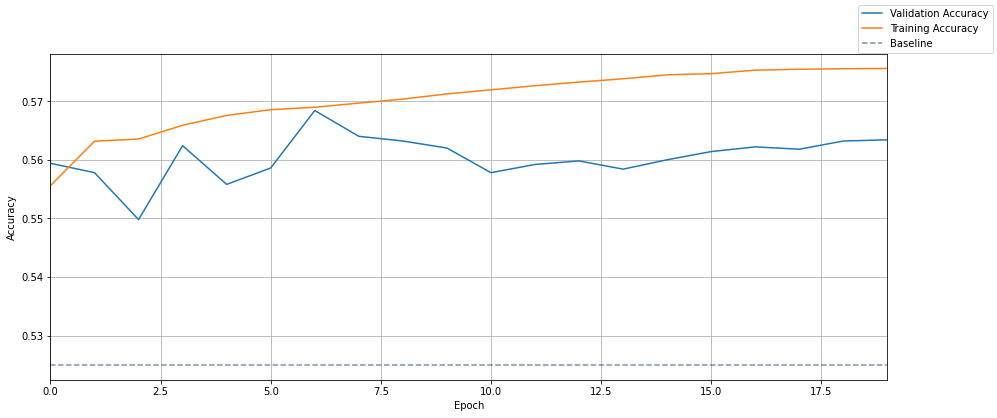

In [26]:
epoch_iota = np.arange(len(train_accuracies))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(epoch_iota, test_accuracies, label='Validation Accuracy')
ax.plot(epoch_iota, train_accuracies, label='Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=0, right=epoch_iota[-1])
baseline_accuracy = 0.525 # From previous notebook.
ax.axhline(baseline_accuracy, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

Our previous curve is below:

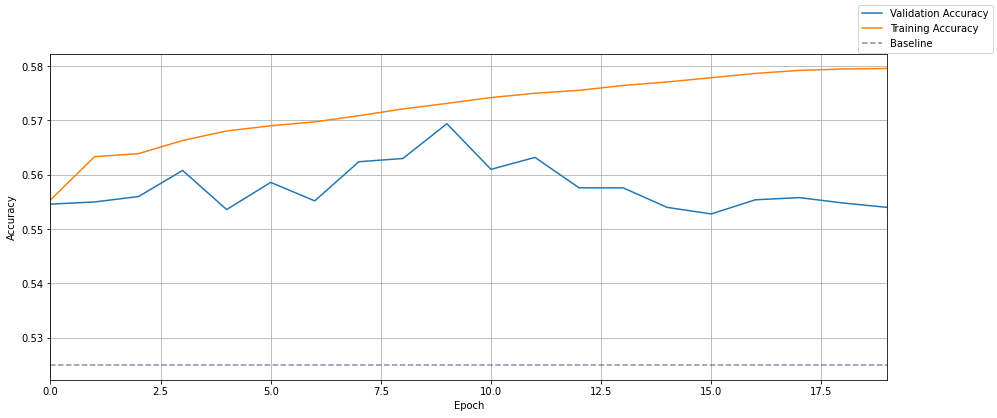

We don't see a better accuracy score (`0.5684` vs `0.5694`) but it does seem like there's less overfitting the later stages of training. 

We might be able to get even better performance if we shuffle on an individual example level instead of a batch level.

In [36]:
# From: https://stackoverflow.com/questions/50554272/randomly-shuffle-items-in-each-row-of-numpy-array
def crazyshuffle(arr):
  x, y = arr.shape
  rows = np.indices((x,y))[0]
  cols = [np.random.permutation(y) for _ in range(x)]
  return arr[rows, cols]

In [70]:
def train_epoch(cfg, state, train_df, rng):
  """Train for a single epoch."""
  train_df_size = len(train_df)
  steps_per_epoch = train_df_size // cfg.batch_size
  
  perms = jax.random.permutation(rng, train_df_size)
  perms = perms[:steps_per_epoch * cfg.batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, cfg.batch_size))
  
  epoch_loss = []
  epoch_accuracy = []

  for perm in perms:
    # Shuffle heroes on each team 
    radiant = np.array([train_df.iloc[perm]['hero0'].values, train_df.iloc[perm]['hero1'].values, 
              train_df.iloc[perm]['hero2'].values, train_df.iloc[perm]['hero3'].values,
              train_df.iloc[perm]['hero4'].values])
    # Shuffle within each sample (batch item)
    radiant = crazyshuffle(radiant.T).T
    batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4 = radiant
    
    dire = np.array([train_df.iloc[perm]['hero5'].values, train_df.iloc[perm]['hero6'].values, 
              train_df.iloc[perm]['hero7'].values, train_df.iloc[perm]['hero8'].values,
              train_df.iloc[perm]['hero9'].values])
    # Shuffle within each sample (batch item)
    dire = crazyshuffle(dire.T).T
    batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9 = dire
    
    batch_heros = (batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4, 
                   batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9)
    
    # y
    batch_radiant_win = train_df.iloc[perm]['radiant_win'].values

    grads, loss, accuracy = apply_model(cfg, state, batch_heros, batch_radiant_win)
    state = update_model(state, grads)
    
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

In [71]:
tf.config.experimental.set_visible_devices([], 'GPU')
config = DotaModelConfig()

state, train_accuracies, test_accuracies = train_and_evaluate(config, train_df, test_df)

epoch:  1, train_loss: 0.6830, train_accuracy: 0.5557, test_loss: 0.6848, test_accuracy: 0.5482
epoch:  2, train_loss: 0.6806, train_accuracy: 0.5631, test_loss: 0.6840, test_accuracy: 0.5544
epoch:  3, train_loss: 0.6805, train_accuracy: 0.5636, test_loss: 0.6856, test_accuracy: 0.5526
epoch:  4, train_loss: 0.6795, train_accuracy: 0.5662, test_loss: 0.6848, test_accuracy: 0.5500
epoch:  5, train_loss: 0.6788, train_accuracy: 0.5675, test_loss: 0.6847, test_accuracy: 0.5540
epoch:  6, train_loss: 0.6787, train_accuracy: 0.5680, test_loss: 0.6835, test_accuracy: 0.5582
epoch:  7, train_loss: 0.6785, train_accuracy: 0.5685, test_loss: 0.6838, test_accuracy: 0.5612
epoch:  8, train_loss: 0.6780, train_accuracy: 0.5696, test_loss: 0.6833, test_accuracy: 0.5652
epoch:  9, train_loss: 0.6777, train_accuracy: 0.5703, test_loss: 0.6823, test_accuracy: 0.5650
epoch: 10, train_loss: 0.6773, train_accuracy: 0.5709, test_loss: 0.6828, test_accuracy: 0.5610
epoch: 11, train_loss: 0.6769, train_acc

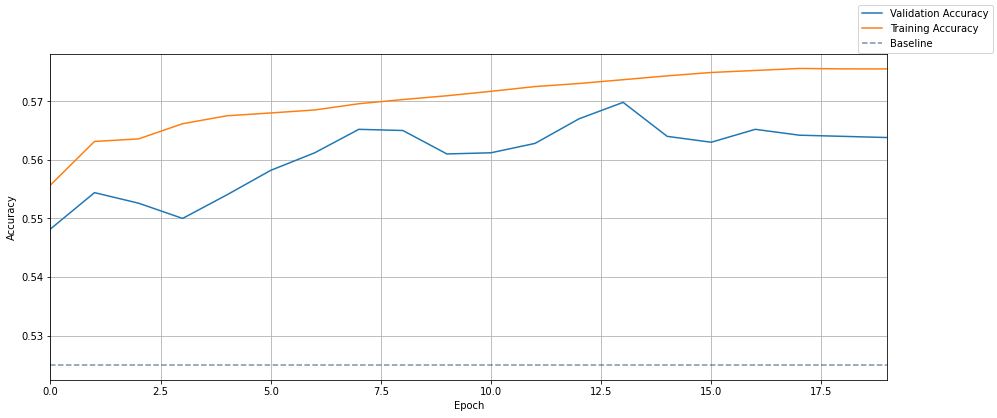

In [72]:
epoch_iota = np.arange(len(train_accuracies))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(epoch_iota, test_accuracies, label='Validation Accuracy')
ax.plot(epoch_iota, train_accuracies, label='Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=0, right=epoch_iota[-1])
baseline_accuracy = 0.525 # From previous notebook.
ax.axhline(baseline_accuracy, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

That seems pretty good! We get a higher test accuracy (`0.5698`)  than either of the previous approaches.

There appears to be less overfitting and our validation curve appears to track more closely to our training curve.